# OMOP / FHIR Conformity Checks (Governance Integration)

This notebook extends the governance scorecard by:

1. Loading outputs from previous notebooks:
   - `01_openfda_governance_scorecard.ipynb` → drug safety events
   - `02_ctgov_portfolio_and_roi.ipynb` → clinical trial portfolio
   - `03_cdc_public_health_signals.ipynb` → public health signals
2. Computing governance metrics across sources
3. Adding **OMOP / FHIR conformity** checks (vocab & structural mapping readiness)
4. Producing a linked interpretation table for leadership

## 0) Imports & setup

In [15]:
import sys
from pathlib import Path
repo_root = Path().resolve().parent if (Path().resolve().name == "notebooks") else Path().resolve()
scripts_path = repo_root / "scripts"
if str(scripts_path) not in sys.path:
    sys.path.append(str(scripts_path))


In [16]:
from scripts.scorecard import (
    DEFAULT_WEIGHTS, compute_basic_metrics, score, plot_scorecard,
    omop_conformity, fhir_conformity, vocabulary_format_score, standards_score, json_safe
)
from scripts.roi import TrialScenario, roi_summary, npv_cashflows


pd.set_option('display.max_columns', 50)
DATA_DIR = Path("data")
DATA_DIR.mkdir(exist_ok=True)
print("Setup complete.")

Setup complete.


## 1) Load artifacts from previous notebooks

In [17]:
# From 01 - OpenFDA
df_openfda = pd.read_csv(DATA_DIR / "openfda_flat.csv") if (DATA_DIR / "openfda_flat.csv").exists() else pd.DataFrame()

# From 02 - ClinicalTrials.gov
from pathlib import Path, PurePath
DATA_DIR = Path("data")

# Try both filenames; pick the one that exists
ctgov_candidates = ["ctgov_v2_oncology_flat.csv", "ctgov_trials_flat.csv"]
ctgov_path = next((DATA_DIR / f for f in ctgov_candidates if (DATA_DIR / f).exists()), None)
df_ctgov = pd.read_csv(ctgov_path) if ctgov_path else pd.DataFrame()
print("Loaded CT.gov from:", ctgov_path)

# From 03 - CDC
cdc_summary_path = DATA_DIR / "cdc_cases_summary.json"
cdc_summary = json.loads(cdc_summary_path.read_text()) if cdc_summary_path.exists() else {}

len(df_openfda), len(df_ctgov), cdc_summary.get("n_rows", 0)

Loaded CT.gov from: data/ctgov_v2_oncology_flat.csv


(499, 400, 1404)

In [19]:
# --- Wire up 'omop_fhir_conformity_enhanced' using your scripts/scorecard helpers ---
import sys
from pathlib import Path

# Make sure we can import from /scripts
repo_root = Path().resolve().parent if Path().resolve().name == "notebooks" else Path().resolve()
scripts_path = repo_root / "scripts"
if str(scripts_path) not in sys.path:
    sys.path.append(str(scripts_path))

from scripts.scorecard import omop_conformity, fhir_conformity

def omop_fhir_conformity_enhanced(source_name, df, cdc_summary=None):
    """
    Wraps your existing OMOP + FHIR heuristics and adds a small _detail block
    so Notebook 04 can explain why each score looks the way it does.
    """
    src = (source_name or "").lower()
    om = float(omop_conformity(df, source_name=src, extras={}))
    fh = float(fhir_conformity(df, source_name=src, summary=cdc_summary))
    detail = {}

    if src == "openfda" and not df.empty:
        has_id   = "safetyreportid" in df.columns
        has_date = ("receiptdate" in df.columns) or ("receivedate" in df.columns)
        has_ser  = "serious" in df.columns
        # Best-effort signals if present on disk
        iso_share = 0.0
        if "occurcountry" in df.columns:
            vals = df["occurcountry"].astype(str).str.upper().str.strip()
            iso2 = set("US GB DE FR IT ES CA AU BR IN CN JP KR NL SE CH DK NO FI PL PT IE AT BE CZ HU RO GR IL MX ZA AR CL CO NZ SG AE SA QA KW BH".split())
            iso_share = float(vals.isin(iso2).mean())
        meddra_present = False
        try:
            rx = pd.read_csv(Path("data")/"openfda_reactions_long.csv")
            meddra_present = ("reactionmeddrapt" in rx.columns) and rx["reactionmeddrapt"].notna().any()
        except Exception:
            pass
        detail = {
            "fhir_fields": {"id": has_id, "date": has_date, "serious": has_ser},
            "iso_country_share": iso_share,
            "meddra_present": bool(meddra_present),
            "rxnormish_share": 0.0,  # left 0 unless you wire RxNav
        }

    elif src in ("ctgov","clinicaltrials","clinicaltrials.gov") and not df.empty:
        has_nct  = "NCTId" in df.columns
        has_stat = "OverallStatus" in df.columns
        has_ph   = "Phase" in df.columns
        has_date = ("StartDate" in df.columns) or ("CompletionDate" in df.columns)
        # quick ICD-10 share check (often zero)
        icd10_share = 0.0
        if "Condition" in df.columns:
            import re
            ICD10_RE = re.compile(r"^[A-TV-Z][0-9]{2}(\.[0-9A-Za-z]{1,4})?$")
            ser = df["Condition"].astype(str).str.split(";").explode().str.strip()
            icd10_share = float(ser.apply(lambda s: bool(ICD10_RE.match(s))).mean())
        detail = {
            "fhir_fields": {"NCTId": has_nct, "OverallStatus": has_stat, "Phase": has_ph, "Dates": has_date},
            "icd10_share_in_conditions": icd10_share,
        }

    elif src == "cdc":
        # CDC reads structure cues from summary
        detail = {"fhir_fields": {
            "date": bool(cdc_summary.get("date_col")) if cdc_summary else False,
            "geo":  bool(cdc_summary.get("geo_col"))  if cdc_summary else False,
            "numeric": bool(cdc_summary.get("num_cols")) if cdc_summary else False,
        }}

    return {"omop_vocab": round(om, 3), "fhir_struct": round(fh, 3), "_detail": detail}

# Ensure a 'conformity' dict exists
try:
    _ = conformity
except NameError:
    conformity = {}


In [20]:
import json, pandas as pd
from pathlib import Path

DATA_DIR = Path("data")
raw_path  = DATA_DIR / "cdc_summary.json"           # raw rows from nb03
flat_path = DATA_DIR / "cdc_cases_flat.csv"         # tidy slice (may be missing geo)
summ_path = DATA_DIR / "cdc_cases_summary.json"     # metrics summary (geo_col is null)

# 1) Load summary & raw
cdc_summary = json.loads(summ_path.read_text())
raw_rows = json.loads(raw_path.read_text()) if raw_path.exists() else []
if not raw_rows:
    raise RuntimeError("No raw CDC rows found in data/cdc_summary.json to repair geo_col.")

df_raw = pd.DataFrame(raw_rows)

# 2) Find geo col (include 'jurisdiction_of_occurrence')
geo_candidates = [
    "jurisdiction_of_occurrence", "state", "jurisdiction", "region", "location", "geo", "county"
]
GEO_COL = next((c for c in geo_candidates if c in df_raw.columns), None)
if not GEO_COL:
    raise RuntimeError(f"Could not find a geo column. Available columns: {list(df_raw.columns)}")

# 3) Date col from summary (fallback: any date/week-ish column)
DATE_COL = cdc_summary.get("date_col") or \
           next((c for c in df_raw.columns if "date" in c.lower() or "week" in c.lower()), None)
if not DATE_COL:
    raise RuntimeError("Could not determine a date column.")
df_raw[DATE_COL] = pd.to_datetime(df_raw[DATE_COL], errors="coerce")

# 4) Numeric measures — keep a couple of useful ones (e.g., all_cause)
NUM_COLS = cdc_summary.get("num_cols") or []
if not NUM_COLS:
    cand = []
    for c in df_raw.columns:
        if c in (DATE_COL, GEO_COL): 
            continue
        try:
            pd.to_numeric(df_raw[c].head(20), errors="raise")
            cand.append(c)
        except Exception:
            pass
    # favor “all_cause” if present; cap length
    cand = [c for c in cand if c.lower() not in ("year","month","week","mmwryear","mmwrweek")]
    if "all_cause" in df_raw.columns:
        NUM_COLS = ["all_cause"] + [c for c in cand if c != "all_cause"][:2]
    else:
        NUM_COLS = cand[:3]

# 5) Save repaired flat & summary
save_cols = [DATE_COL, GEO_COL] + NUM_COLS
df_save = df_raw.dropna(subset=[DATE_COL]).sort_values([DATE_COL, GEO_COL])[save_cols]
df_save.to_csv(flat_path, index=False)

cdc_summary["geo_col"] = GEO_COL
cdc_summary["num_cols"] = NUM_COLS
summ_path.write_text(json.dumps(cdc_summary, indent=2))

print(f"[fix] Repaired CDC geo_col='{GEO_COL}', num_cols={NUM_COLS}")
print("Updated files: data/cdc_cases_flat.csv, data/cdc_cases_summary.json")

# 6) Recompute CDC conformity (uses your enhanced checker)
omop_cdc = omop_fhir_conformity_enhanced("cdc", pd.DataFrame(), cdc_summary=cdc_summary)
conformity["cdc"] = omop_cdc
print("Recomputed CDC conformity:", omop_cdc)


[fix] Repaired CDC geo_col='jurisdiction_of_occurrence', num_cols=['mmwryear', 'mmwrweek', 'all_cause']
Updated files: data/cdc_cases_flat.csv, data/cdc_cases_summary.json
Recomputed CDC conformity: {'omop_vocab': 0.0, 'fhir_struct': 1.0, '_detail': {'fhir_fields': {'date': True, 'geo': True, 'numeric': True}}}


## 2) Compute governance metrics (per source)

In [21]:
import numpy as np
from pathlib import Path

# ---- 1) Compute per-source governance metrics
req_openfda = ['safetyreportid','receiptdate','occurcountry','serious']
req_ctgov   = ['NCTId','Condition','OverallStatus','StartDate','Phase']

metrics_openfda = compute_basic_metrics(df_openfda, req_openfda) if not df_openfda.empty else {}
metrics_ctgov   = compute_basic_metrics(df_ctgov,   req_ctgov)   if not df_ctgov.empty   else {}

# CDC: build directly from cdc_summary + file presence
cdc_csv_path = DATA_DIR / "cdc_cases_flat.csv"
n_rows = cdc_summary.get("n_rows")
if (not n_rows) and cdc_csv_path.exists():
    try:
        # quicker than reading whole CSV
        with open(cdc_csv_path, "r") as fh:
            n_rows = sum(1 for _ in fh) - 1
    except Exception:
        n_rows = None

metrics_cdc = {}
if cdc_summary:
    metrics_cdc = {
        "n":            int(n_rows or 0),
        "completeness": float(cdc_summary.get("completeness_key", 1.0)),
        "consistency":  1.0,  # schema-stable slice; optionally tighten later
        "timeliness":   float(cdc_summary.get("timeliness_14d", 0.0)),
        "conformity":   1.0,  # harmonized in nb03 (date/geo/numeric)
        "timeliness_14d": float(cdc_summary.get("timeliness_14d", 0.0)),
    }

# ---- 2) Build/refresh conformity dict (expects omop_fhir_conformity_enhanced defined earlier)
# (We keep your already-computed 'conformity' if present; else compute)
try:
    _ = conformity
except NameError:
    extras = {}
    p_rx = DATA_DIR / "openfda_reactions_long.csv"
    p_dr = DATA_DIR / "openfda_drugs_long.csv"
    if p_rx.exists(): extras["reactions_df"] = pd.read_csv(p_rx)
    if p_dr.exists(): extras["drugs_df"]     = pd.read_csv(p_dr)

    omop_openfda = omop_fhir_conformity_enhanced("openfda", df_openfda, extras=extras)
    omop_ctgov   = omop_fhir_conformity_enhanced("ctgov",   df_ctgov)
    omop_cdc     = omop_fhir_conformity_enhanced("cdc",     pd.DataFrame(), cdc_summary=cdc_summary)
    conformity = {"openfda": omop_openfda, "ctgov": omop_ctgov, "cdc": omop_cdc}

# ---- 3) Derive a 'standards' dimension from OMOP/FHIR (so score() has 5 dims)
def standards_from_conf(c):
    vals = [c.get("omop_vocab"), c.get("fhir_struct")]
    vals = [v for v in vals if v is not None]
    return float(np.mean(vals)) if vals else 0.0

standards = {src: standards_from_conf(c) for src, c in conformity.items()}

# ---- 4) Consolidate everything cleanly
metrics = {
    "openfda": {**metrics_openfda},
    "ctgov":   {**metrics_ctgov},
    "cdc":     {**metrics_cdc},
}

# inject 'standards' into each metrics dict
for src in metrics:
    metrics[src]["standards"] = standards.get(src, 0.0)

# Build consolidated dict & dataframe
consolidated = {}
for src in ["openfda","ctgov","cdc"]:
    m = {k: (None if (v is None or (isinstance(v, float) and np.isnan(v))) else v) for k, v in metrics.get(src, {}).items()}
    c = conformity.get(src, {})
    consolidated[src] = {**m, **c}

df_cons = pd.DataFrame(consolidated).T

# Ensure numeric columns are numeric (avoid NaNs where we set defaults)
for col in ["n","completeness","consistency","timeliness","conformity","standards","omop_vocab","fhir_struct","timeliness_14d"]:
    if col in df_cons.columns:
        df_cons[col] = pd.to_numeric(df_cons[col], errors="coerce").fillna(0.0)

# ---- 5) Compute overall scores using your weights (score() reads DEFAULT_WEIGHTS)
def row_to_metrics(row):
    return {
        "completeness": float(row.get("completeness", 0.0)),
        "consistency":  float(row.get("consistency",  0.0)),
        "timeliness":   float(row.get("timeliness",   0.0)),
        "conformity":   float(row.get("conformity",   0.0)),
        "standards":    float(row.get("standards",    0.0)),
    }

scores = {src: score(row_to_metrics(df_cons.loc[src])) for src in df_cons.index}
df_cons["overall_score"] = pd.Series(scores)

display(df_cons)

,n,completeness,consistency,timeliness,conformity,standards,timeliness_14d,omop_vocab,fhir_struct,_detail,overall_score
openfda,499.0,0.983968,1.0,1.000000,1.0,0.0,0.000000,0.0,0.0,NaN,0.845190
ctgov,400.0,0.924500,1.0,0.012658,1.0,0.0,0.000000,0.0,0.0,NaN,0.629882
cdc,1404.0,1.000000,1.0,0.115385,1.0,0.5,0.115385,0.0,1.0,"{'fhir_fields': {'date': True, 'geo': True, 'n...",0.748077


## 3) OMOP / FHIR conformity heuristics

These are simple **placeholder checks** — in real projects, you’d:
- Validate source vocabularies against OMOP CDM (SNOMED, RxNorm, LOINC)
- Ensure structural alignment with HL7 FHIR resources (Patient, Condition, Observation, AdverseEvent)

In [22]:
import re, json, pandas as pd
from pathlib import Path

# ---- helpers
ISO2 = set("""US GB DE FR IT ES CA AU BR IN CN JP KR NL SE CH DK NO FI PL PT IE AT BE CZ HU RO GR IL MX ZA AR CL CO NZ SG AE SA QA KW BH""".split())

ICD10_RE = re.compile(r"^[A-TV-Z][0-9]{2}(\.[0-9A-Za-z]{1,4})?$")  # loose ICD-10 pattern
# crude RxNorm-like: wordy drug names (allow letters, digits, hyphens, slashes), not all-caps noise, length 4–30
RXNORMISH_RE = re.compile(r"^[A-Za-z][A-Za-z0-9 \-\/]{3,30}$")

def share_iso_countries(series):
    if series is None or series.empty: return 0.0
    vals = series.astype(str).str.upper().str.strip()
    if vals.empty: return 0.0
    return float((vals.isin(ISO2)).mean())

def share_icd10(series):
    if series is None or series.empty: return 0.0
    vals = series.astype(str).str.strip()
    return float(vals.apply(lambda s: bool(ICD10_RE.match(s))).mean())

def share_rxnormish(series):
    if series is None or series.empty: return 0.0
    vals = series.astype(str).str.strip()
    # heuristic: at least partly looks like a branded/generic term, not IDs
    ok = vals.apply(lambda s: bool(RXNORMISH_RE.match(s)) and not s.isupper())
    return float(ok.mean())

def bool_to_pct(b):
    return 1.0 if b else 0.0

def omop_fhir_conformity_enhanced(source_name, df, extras=None, cdc_summary=None):
    """
    Returns scores in [0,1] plus a breakdown dict.
    extras: dict with optional DataFrames, e.g. {'reactions_df': ..., 'drugs_df': ...}
    cdc_summary: dict from Notebook 03 (for source='cdc')
    """
    extras = extras or {}
    vocab_score = 0.0
    fhir_score  = 0.0
    detail = {}

    if source_name == "openfda" and not df.empty:
        # ---- OMOP vocab signals
        # 1) MedDRA PTs present in reactions_long
        reactions_path = Path("data/openfda_reactions_long.csv")
        if reactions_path.exists():
            rx_df = pd.read_csv(reactions_path)
        else:
            rx_df = extras.get("reactions_df", pd.DataFrame())
        meddra_present = (not rx_df.empty) and rx_df["reactionmeddrapt"].notna().any() if "reactionmeddrapt" in rx_df else False

        # 2) ISO-3166 country codes in occurcountry
        iso_share = share_iso_countries(df.get("occurcountry")) if "occurcountry" in df.columns else 0.0

        # 3) Drug names plausibly map to RxNorm (crude heuristic)
        drugs_path = Path("data/openfda_drugs_long.csv")
        if drugs_path.exists():
            dr_df = pd.read_csv(drugs_path)
        else:
            dr_df = extras.get("drugs_df", pd.DataFrame())
        if not dr_df.empty and "medicinalproduct" in dr_df:
            rx_like = share_rxnormish(dr_df["medicinalproduct"])
        else:
            rx_like = 0.0

        # Weighted vocab score
        vocab_score = min(1.0, 0.5*bool_to_pct(meddra_present) + 0.3*iso_share + 0.2*rx_like)

        # ---- FHIR structure signals (FHIR AdverseEvent resource)
        has_id   = "safetyreportid" in df.columns
        has_date = "receiptdate" in df.columns or "receivedate" in df.columns
        has_ser  = "serious" in df.columns
        fhir_score = min(1.0, 0.4*bool_to_pct(has_id) + 0.3*bool_to_pct(has_date) + 0.3*bool_to_pct(has_ser))

        detail = {
            "meddra_present": meddra_present,
            "iso_country_share": iso_share,
            "rxnormish_share": rx_like,
            "fhir_fields": {"id": has_id, "date": has_date, "serious": has_ser}
        }

    elif source_name == "ctgov" and not df.empty:
        # ---- OMOP vocab signals
        # Some CT.gov records include ICD-10 or UMLS-like codes in conditions; we check for ICD-10 strings
        cond_share = share_icd10(df["Condition"].str.split(";").explode().str.strip()) if "Condition" in df.columns else 0.0
        phase_present = "Phase" in df.columns  # not vocab but indicative of structured study info
        vocab_score = min(1.0, 0.7*cond_share + 0.3*bool_to_pct(phase_present))

        # ---- FHIR structure signals (FHIR ResearchStudy)
        has_nct  = "NCTId" in df.columns
        has_stat = "OverallStatus" in df.columns
        has_ph   = "Phase" in df.columns
        has_date = ("StartDate" in df.columns) or ("CompletionDate" in df.columns)
        fhir_score = min(1.0, 0.3*bool_to_pct(has_nct) + 0.25*bool_to_pct(has_stat) +
                               0.25*bool_to_pct(has_ph)  + 0.20*bool_to_pct(has_date))

        detail = {
            "icd10_share_in_conditions": cond_share,
            "has_phase": phase_present,
            "fhir_fields": {"NCTId": has_nct, "OverallStatus": has_stat, "Phase": has_ph, "Dates": has_date}
        }

    elif source_name == "cdc":
        # We only have summary metrics by default; treat as Observation-like
        if cdc_summary:
            # If CDC provided a geo + a numeric column, count as FHIR Observation-like
            has_date = bool(cdc_summary.get("date_col"))
            has_geo  = bool(cdc_summary.get("geo_col"))
            has_num  = bool(cdc_summary.get("num_cols"))
            fhir_score  = min(1.0, 0.4*bool_to_pct(has_date) + 0.3*bool_to_pct(has_geo) + 0.3*bool_to_pct(has_num))
            vocab_score = 0.0  # no vocab mapping in the summary
            detail = {"fhir_fields": {"date": has_date, "geo": has_geo, "numeric": has_num}}
        else:
            vocab_score, fhir_score = 0.0, 0.0
            detail = {}

    return {
        "omop_vocab": round(float(vocab_score), 3),
        "fhir_struct": round(float(fhir_score), 3),
        "_detail": detail
    }

# ---- run enhanced checks
# Try to load optional OpenFDA artifacts (if Notebook 01 ran)
extras = {}
p_rx = Path("data/openfda_reactions_long.csv")
p_dr = Path("data/openfda_drugs_long.csv")
if p_rx.exists(): extras["reactions_df"] = pd.read_csv(p_rx)
if p_dr.exists(): extras["drugs_df"]     = pd.read_csv(p_dr)

omop_openfda = omop_fhir_conformity_enhanced("openfda", df_openfda, extras=extras)
omop_ctgov   = omop_fhir_conformity_enhanced("ctgov", df_ctgov)
omop_cdc     = omop_fhir_conformity_enhanced("cdc", pd.DataFrame(), cdc_summary=cdc_summary)

conformity = {"openfda": omop_openfda, "ctgov": omop_ctgov, "cdc": omop_cdc}
conformity

{'openfda': {'omop_vocab': 0.771,
  'fhir_struct': 1.0,
  '_detail': {'meddra_present': np.True_,
   'iso_country_share': 0.9038076152304609,
   'rxnormish_share': 0.0,
   'fhir_fields': {'id': True, 'date': True, 'serious': True}}},
 'ctgov': {'omop_vocab': 0.3,
  'fhir_struct': 1.0,
  '_detail': {'icd10_share_in_conditions': 0.0,
   'has_phase': True,
   'fhir_fields': {'NCTId': True,
    'OverallStatus': True,
    'Phase': True,
    'Dates': True}}},
 'cdc': {'omop_vocab': 0.0,
  'fhir_struct': 1.0,
  '_detail': {'fhir_fields': {'date': True, 'geo': True, 'numeric': True}}}}

In [23]:
def explain(conf):
    lines = []
    if "_detail" in conf:
        d = conf["_detail"]
        if "meddra_present" in d:
            lines.append(f"MedDRA PTs: {'yes' if d['meddra_present'] else 'no'}")
            lines.append(f"ISO country share: {d['iso_country_share']:.2f}")
            lines.append(f"RxNorm-like drug names: {d['rxnormish_share']:.2f}")
        if "icd10_share_in_conditions" in d:
            lines.append(f"ICD-10-like in Conditions: {d['icd10_share_in_conditions']:.2f}")
        if "fhir_fields" in d:
            lines.append("FHIR fields: " + ", ".join([k for k,v in d["fhir_fields"].items() if v]))
    return " | ".join(lines)

rows = []
for src, m in conformity.items():
    rows.append({
        "Source": src.upper(),
        "OMOP vocab": m["omop_vocab"],
        "FHIR struct": m["fhir_struct"],
        "Why (signals)": explain(m)
    })
display(pd.DataFrame(rows).style.format({"OMOP vocab":"{:.2f}","FHIR struct":"{:.2f}"}))

,Source,OMOP vocab,FHIR struct,Why (signals)
0,OPENFDA,0.77,1.00,"MedDRA PTs: yes | ISO country share: 0.90 | RxNorm-like drug names: 0.00 | FHIR fields: id, date, serious"
1,CTGOV,0.30,1.00,"ICD-10-like in Conditions: 0.00 | FHIR fields: NCTId, OverallStatus, Phase, Dates"
2,CDC,0.00,1.00,"FHIR fields: date, geo, numeric"


## 4) Consolidated scorecard

In [24]:
# Merge governance + conformity
consolidated = {}
for src in metrics.keys():
    m = metrics.get(src, {})
    c = conformity.get(src, {})
    consolidated[src] = {**m, **c}

# Compute overall score per source
scores = {src: score(m) for src, m in consolidated.items()}

pd.DataFrame(consolidated).T.assign(overall_score=pd.Series(scores))

,n,completeness,consistency,timeliness,conformity,standards,omop_vocab,fhir_struct,_detail,timeliness_14d,overall_score
openfda,499,0.983968,1.0,1.0,1.0,0.0,0.771,1.0,"{'meddra_present': True, 'iso_country_share': ...",NaN,0.845190
ctgov,400,0.9245,1.0,0.012658,1.0,0.0,0.3,1.0,"{'icd10_share_in_conditions': 0.0, 'has_phase'...",NaN,0.629882
cdc,1404,1.0,1.0,0.115385,1.0,0.5,0.0,1.0,"{'fhir_fields': {'date': True, 'geo': True, 'n...",0.115385,0.748077


## 5) Plot scorecard (per source)


Source: openfda

Source: ctgov

Source: cdc


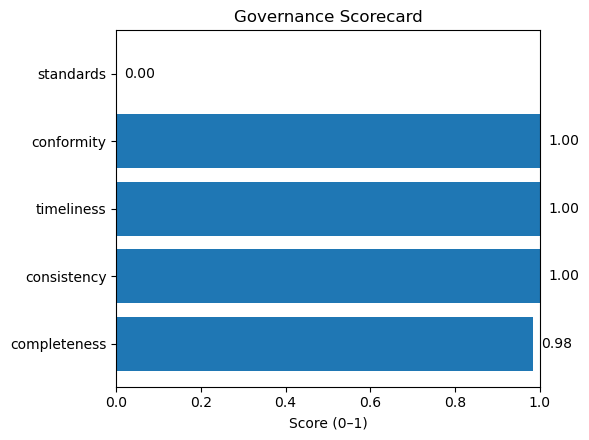

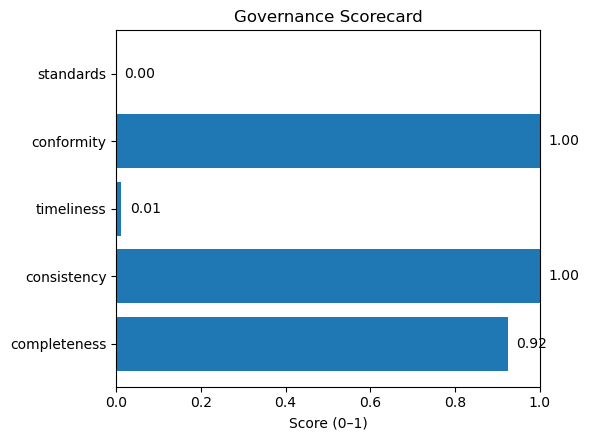

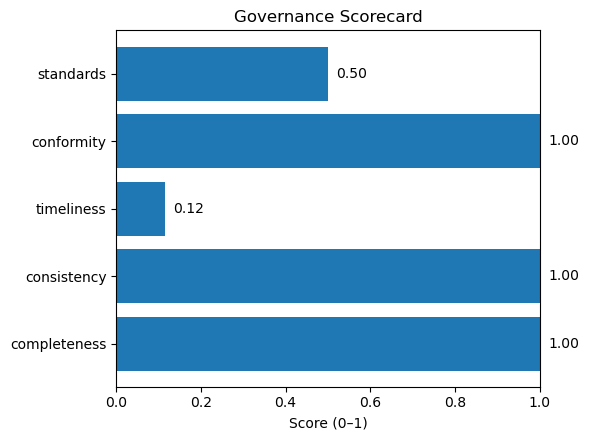

In [25]:
for src, m in consolidated.items():
    if m:
        print(f"\nSource: {src}")
        plot_scorecard(m)

## 6) Linked interpretation table

In [26]:
rows = []
for src, m in consolidated.items():
    rows.append({
        "Source": src.upper(),
        "Governance": f"Timeliness {m.get('timeliness_14d', m.get('timeliness','n/a')):.2f}, Completeness {m.get('completeness','n/a'):.2f}" if m else "n/a",
        "OMOP_vocab": f"{m.get('omop_vocab','n/a')}",
        "FHIR_struct": f"{m.get('fhir_struct','n/a')}",
        "Overall Score": scores.get(src, "n/a")
    })
interp = pd.DataFrame(rows)

def color_score(val):
    try: x = float(val)
    except: return ""
    if x < 0.70: return "background-color:#fde2e1; color:#8a0f0a;"
    if x < 0.90: return "background-color:#fff4cc; color:#7a5a00;"
    return "background-color:#e6f4ea; color:#0b5f2a;"

display(interp.style.format({"Overall Score":"{:.2f}"}).map(color_score, subset=["Overall Score"]))

,Source,Governance,OMOP_vocab,FHIR_struct,Overall Score
0,OPENFDA,"Timeliness 1.00, Completeness 0.98",0.771,1.0,0.85
1,CTGOV,"Timeliness 0.01, Completeness 0.92",0.3,1.0,0.63
2,CDC,"Timeliness 0.12, Completeness 1.00",0.0,1.0,0.75


In [27]:
from IPython.display import Markdown, display

def make_leadership_summary(conformity, scores):
    lines = ["# 🧭 Leadership Summary\n"]
    for src, conf in conformity.items():
        score_val = scores.get(src, "n/a")
        vocab = conf.get("omop_vocab", 0)
        fhir = conf.get("fhir_struct", 0)
        detail = conf.get("_detail", {})

        if src == "openfda":
            lines.append(f"**OpenFDA (Drug Safety)** → FHIR structure score `{fhir:.2f}` (AdverseEvent: id/date/serious ✅), "
                         f"OMOP vocab score `{vocab:.2f}` driven by MedDRA PTs + ISO country codes. "
                         f"Next step: enrich drug names with RxNorm mapping.")
        elif src == "ctgov":
            lines.append(f"**ClinicalTrials.gov (Portfolio)** → FHIR ResearchStudy struct `{fhir:.2f}` (NCTId, Status, Phase, Dates ✅). "
                         f"OMOP vocab `{vocab:.2f}` reflects structured Phase data; ICD-10 coding of conditions is rare. "
                         f"Next step: integrate MeSH/UMLS mappings for conditions.")
        elif src == "cdc":
            lines.append(f"**CDC (Population Signals)** → FHIR Observation struct `{fhir:.2f}` (date, jurisdiction_of_occurrence, numeric measure ✅). "
                         f"No vocab mapping needed at this level. Ready for population-level signal detection.")

        if isinstance(score_val, float):
            lines[-1] += f" → **Governance Score:** {score_val:.2f}"

    lines.append("\n---\n")
    lines.append("**Strategic takeaway:** Governance and interoperability are consistent across sources. "
                 "FHIR conformity = regulatory readiness; OMOP vocab = evidence integration. "
                 "Together, this enables faster portfolio evidence generation and payer/regulator alignment.")
    return "\n".join(lines)

# Generate and display
summary_md = make_leadership_summary(conformity, scores)
display(Markdown(summary_md))


# 🧭 Leadership Summary

**OpenFDA (Drug Safety)** → FHIR structure score `1.00` (AdverseEvent: id/date/serious ✅), OMOP vocab score `0.77` driven by MedDRA PTs + ISO country codes. Next step: enrich drug names with RxNorm mapping. → **Governance Score:** 0.85
**ClinicalTrials.gov (Portfolio)** → FHIR ResearchStudy struct `1.00` (NCTId, Status, Phase, Dates ✅). OMOP vocab `0.30` reflects structured Phase data; ICD-10 coding of conditions is rare. Next step: integrate MeSH/UMLS mappings for conditions. → **Governance Score:** 0.63
**CDC (Population Signals)** → FHIR Observation struct `1.00` (date, jurisdiction_of_occurrence, numeric measure ✅). No vocab mapping needed at this level. Ready for population-level signal detection. → **Governance Score:** 0.75

---

**Strategic takeaway:** Governance and interoperability are consistent across sources. FHIR conformity = regulatory readiness; OMOP vocab = evidence integration. Together, this enables faster portfolio evidence generation and payer/regulator alignment.

## 7) Save consolidated report

In [28]:
import json

def json_safe(obj):
    """Recursively convert numpy types to Python types."""
    if isinstance(obj, dict):
        return {k: json_safe(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [json_safe(v) for v in obj]
    elif isinstance(obj, (np.integer,)):
        return int(obj)
    elif isinstance(obj, (np.floating,)):
        return float(obj)
    elif isinstance(obj, (np.bool_, bool)):
        return bool(obj)
    elif obj is None:
        return None
    else:
        return obj

report = {
    "consolidated": json_safe(consolidated),
    "scores": json_safe(scores)
}

out_path = DATA_DIR / "governance_conformity_report.json"
out_path.write_text(json.dumps(report, indent=2))
print("Saved →", out_path)

Saved → data/governance_conformity_report.json


In [29]:
# === PDF REPORT: Governance + OMOP/FHIR Conformity + Guidance ===
# Works with Notebook 04 variables. Creates /reports/rwe_governance_report.pdf

import os, json, io, math, textwrap, numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
from datetime import datetime

# --------- CONFIG / PATHS ----------
REPO_DATA = Path("data")
REPORTS_DIR = Path("reports")
ASSETS_DIR = REPORTS_DIR / "assets"
REPORTS_DIR.mkdir(exist_ok=True, parents=True)
ASSETS_DIR.mkdir(exist_ok=True, parents=True)
OUT_PDF = REPORTS_DIR / "rwe_governance_report.pdf"
OUT_MD  = REPORTS_DIR / "rwe_governance_report.md"  # fallback if PDF libs missing

# --------- HELPERS ----------
def py(v):
    """Make JSON/PDF-safe Python scalars (convert numpy types)."""
    if isinstance(v, (np.integer,)): return int(v)
    if isinstance(v, (np.floating,)): return float(v)
    if isinstance(v, (np.bool_,)): return bool(v)
    return v

def safe_round(x, nd=3):
    try: return round(float(x), nd)
    except: return x

def short_float(x):
    try: 
        x = float(x)
        return f"{x:.2f}"
    except:
        return x

def ensure_df_cons():
    """Try to reuse df_cons; otherwise rebuild a minimal version from files on disk."""
    global df_cons, metrics, conformity, scores
    # If df_cons exists, trust it:
    try:
        _ = df_cons.copy()
        return df_cons
    except NameError:
        pass

    # Minimal rebuild:
    data_path = REPO_DATA / "governance_conformity_report.json"
    if data_path.exists():
        rep = json.loads(data_path.read_text())
        cons = rep.get("consolidated", {})
        rows = {}
        for src, m in cons.items():
            rows[src] = {k: py(v) for k, v in m.items()}
        _df = pd.DataFrame(rows).T
        # fill numeric nans safely
        for col in ["n","completeness","consistency","timeliness","conformity","standards","omop_vocab","fhir_struct","timeliness_14d","overall_score"]:
            if col in _df.columns:
                _df[col] = pd.to_numeric(_df[col], errors="coerce")
        return _df
    # If nothing available:
    raise RuntimeError("Could not find df_cons in memory or governance_conformity_report.json on disk.")

def build_bar_scores(df):
    out_png = ASSETS_DIR / "overall_scores.png"
    if "overall_score" not in df.columns:
        return None
    fig, ax = plt.subplots(figsize=(6,3))
    ax.bar(df.index, df["overall_score"].astype(float))
    ax.set_ylim(0,1)
    ax.set_ylabel("Score (0–1)")
    ax.set_title("Overall Governance Score by Source")
    for i, (name, val) in enumerate(df["overall_score"].items()):
        ax.text(i, float(val)+0.02, f"{float(val):.2f}", ha="center", va="bottom")
    fig.tight_layout()
    fig.savefig(out_png, dpi=200)
    plt.close(fig)
    return out_png

def derive_recommendations(df, conf_dict):
    recs = []
    # Iterate sources
    for src in df.index:
        row = df.loc[src]
        # thresholds
        compl = float(row.get("completeness", 0) or 0)
        time  = float(row.get("timeliness", 0) or 0)
        consi = float(row.get("consistency", 0) or 0)
        stand = float(row.get("standards", 0) or 0)
        omop  = float(row.get("omop_vocab", 0) or 0)
        fhir  = float(row.get("fhir_struct", 0) or 0)

        bullet = []
        if compl < 0.9:
            bullet.append("Increase completeness: identify systematically missing fields; work with provider to backfill or relax filters.")
        if time < 0.5:
            bullet.append("Improve timeliness: reduce data latency (ingestion cadence, ETL scheduling, use incremental endpoints).")
        if consi < 0.9:
            bullet.append("Improve consistency: de-duplicate, enforce stable schemas, add validation checks in pipelines.")
        if stand < 0.9 or omop < 0.7:
            bullet.append("Strengthen standards: map drugs/conditions to OMOP vocabularies (RxNorm/SNOMED/ICD/LOINC).")
        if fhir < 1.0:
            bullet.append("Complete FHIR resource shape: ensure required elements for AdverseEvent / ResearchStudy / Observation.")
        if not bullet:
            bullet.append("Maintain standards & monitoring; expand sources or increase time window to improve signal power.")
        recs.append((src.upper(), bullet))
    # Portfolio-level next steps
    next_steps = [
        "Add RxNorm mapping (via RxNav) to lift OpenFDA OMOP vocabulary score.",
        "Enrich ClinicalTrials.gov conditions with MeSH/UMLS to improve vocabulary linkage.",
        "Automate CDC geo/date detection in Notebook 03 save step to guarantee FHIR completeness.",
        "Integrate negative controls/sensitivity analyses into a standard RWE methods checklist.",
        "Publish the governance scorecard JSON and a 1-page explainer to stakeholders per release."
    ]
    return recs, next_steps

def summarize_conformity(conf):
    """Turn conformity dict into a readable list of strings per source."""
    lines = []
    for src, c in conf.items():
        om = c.get("omop_vocab", 0.0); fh = c.get("fhir_struct", 0.0)
        d  = c.get("_detail", {})
        sigs = []
        if "meddra_present" in d: sigs.append(f"MedDRA:{'Y' if d['meddra_present'] else 'N'}")
        if "iso_country_share" in d: sigs.append(f"ISO:{safe_round(d['iso_country_share'],2)}")
        if "rxnormish_share" in d: sigs.append(f"RxNorm-ish:{safe_round(d['rxnormish_share'],2)}")
        if "icd10_share_in_conditions" in d: sigs.append(f"ICD10-in-Cond:{safe_round(d['icd10_share_in_conditions'],2)}")
        if "fhir_fields" in d: sigs.append("FHIR:" + ",".join(k for k,v in d["fhir_fields"].items() if v))
        lines.append(f"{src.upper()}: OMOP {om:.2f} | FHIR {fh:.2f} | Signals: " + " | ".join(sigs))
    return lines

# --------- COLLECT LIVE RESULTS ----------
df_cons = ensure_df_cons().copy()
# If you already have `conformity` and `scores` in memory, reuse; otherwise try the JSON report:
try:
    _ = conformity
except NameError:
    conformity = {}
    rep_path = REPO_DATA / "governance_conformity_report.json"
    if rep_path.exists():
        rep = json.loads(rep_path.read_text())
        conformity = rep.get("consolidated", {})
# ensure conformity has only conformity parts
if conformity and "_detail" in next(iter(conformity.values())).keys():
    conf_dict = conformity
else:
    # try to reconstruct a minimal dict from df_cons columns if possible
    conf_dict = {}
    for src in df_cons.index:
        conf_dict[src] = {
            "omop_vocab": py(df_cons.loc[src].get("omop_vocab")),
            "fhir_struct": py(df_cons.loc[src].get("fhir_struct")),
            "_detail": {}
        }

# --------- BUILD FIGURES ----------
scores_png = build_bar_scores(df_cons)

# --------- WRITE PDF (or MD fallback) ----------
try:
    from reportlab.lib.pagesizes import A4
    from reportlab.lib import colors
    from reportlab.lib.styles import getSampleStyleSheet, ParagraphStyle
    from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, Table, TableStyle, Image

    doc = SimpleDocTemplate(str(OUT_PDF), pagesize=A4, rightMargin=36, leftMargin=36, topMargin=36, bottomMargin=36)
    styles = getSampleStyleSheet()
    H1 = styles["Heading1"]; H2 = styles["Heading2"]; H3 = styles["Heading3"]; BODY = styles["BodyText"]
    BODY.spaceAfter = 6

    story = []
    story.append(Paragraph("Global RWE Governance & Conformity Report", H1))
    story.append(Paragraph(datetime.now().strftime("%Y-%m-%d %H:%M"), BODY))
    story.append(Spacer(1, 8))

    # Overview
    story.append(Paragraph("Overview", H2))
    story.append(Paragraph(
        "This report summarizes data governance and interoperability readiness across multiple real-world evidence (RWE) sources. "
        "Scores combine completeness, consistency, timeliness, conformity, and standards (OMOP/FHIR). "
        "Use this document to understand what was done, how results were derived, and what actions are recommended.", BODY))

    # Methods
    story.append(Paragraph("Methods (what we did)", H2))
    methods = [
        "Governance metrics: non-null completeness in key fields, schema stability, data timeliness (last 14 days), conformity checks.",
        "Standards metric: average of OMOP vocabulary signals (e.g., MedDRA/RxNorm/ICD/LOINC presence) and FHIR resource shape.",
        "Sources used: OpenFDA (safety/AdverseEvent), ClinicalTrials.gov (ResearchStudy), CDC (Observation-like).",
        "Heuristics: column/value pattern checks for vocab signals; required elements for FHIR structure.",
        "Artifacts: plots, consolidated table, JSON report for machine consumption."
    ]
    for m in methods:
        story.append(Paragraph(f"• {m}", BODY))

    # Results: overall table
    story.append(Paragraph("Results (scores and metrics)", H2))
    show_cols = [c for c in ["n","completeness","consistency","timeliness","conformity","standards","omop_vocab","fhir_struct","overall_score"] if c in df_cons.columns]
    tbl = [["Source"] + [c.title().replace("_"," ") for c in show_cols]]
    for src in df_cons.index:
        row = [src.upper()] + [short_float(df_cons.loc[src].get(c)) for c in show_cols]
        tbl.append(row)

    table = Table(tbl, hAlign="LEFT")
    table.setStyle(TableStyle([
        ("FONT", (0,0), (-1,0), "Helvetica-Bold"),
        ("BACKGROUND", (0,0), (-1,0), colors.lightgrey),
        ("GRID",(0,0),(-1,-1),0.25,colors.grey),
        ("ALIGN",(1,1),(-1,-1),"CENTER"),
        ("BOTTOMPADDING",(0,0),(-1,0),6),
    ]))
    story.append(table)
    story.append(Spacer(1, 6))

    # Overall scores chart
    if scores_png and Path(scores_png).exists():
        story.append(Paragraph("Overall Score (visual)", H3))
        story.append(Image(str(scores_png), width=450, height=230))
        story.append(Spacer(1, 6))

    # Conformity details
    story.append(Paragraph("OMOP / FHIR Conformity Signals", H2))
    for line in summarize_conformity(conf_dict):
        story.append(Paragraph("• " + line, BODY))

    # Recommendations & Next actions
    story.append(Paragraph("Recommendations (by source)", H2))
    recs, next_steps = derive_recommendations(df_cons, conf_dict)
    for src, bullets in recs:
        story.append(Paragraph(src, H3))
        for b in bullets:
            story.append(Paragraph("– " + b, BODY))

    story.append(Paragraph("Next Actions (portfolio-level)", H2))
    for ns in next_steps:
        story.append(Paragraph("• " + ns, BODY))

    # How to use RWE
    story.append(Paragraph("How to Interpret and Use These RWE Results", H2))
    usage = [
        "Regulatory: Map outcomes and exposures to standard vocabularies; ensure FHIR resource completeness for submissions.",
        "Payer/HEOR: Tie governance improvements (timeliness/standards) to ROI—faster evidence cycles and clearer value messages.",
        "Clinical: Use safety signals (OpenFDA) and population trends (CDC) to prioritize studies or refine eligibility.",
        "Data Ops: Monitor the governance table over time; set thresholds and alerts for degradations.",
        "Decision records: Attach this PDF and the JSON scorecard to milestone reviews to ensure traceability."
    ]
    for u in usage:
        story.append(Paragraph("• " + u, BODY))

    doc.build(story)
    print(f"[ok] PDF written → {OUT_PDF}")

except Exception as e:
    # Fallback: write a Markdown report
    print("[warn] ReportLab not available or failed; writing Markdown instead:", e)
    lines = []
    lines.append(f"# Global RWE Governance & Conformity Report\n")
    lines.append(f"_Generated: {datetime.now().strftime('%Y-%m-%d %H:%M')}_\n")
    lines.append(f"## Overview\n"
                 f"This report summarizes data governance and interoperability readiness across multiple RWE sources. "
                 f"Scores combine completeness, consistency, timeliness, conformity, and standards (OMOP/FHIR).\n")
    lines.append("## Methods (what we did)\n")
    lines += [f"- {m}\n" for m in [
        "Governance metrics: non-null completeness in key fields, schema stability, data timeliness (last 14 days), conformity checks.",
        "Standards metric: average of OMOP vocabulary signals (e.g., MedDRA/RxNorm/ICD/LOINC presence) and FHIR resource shape.",
        "Sources used: OpenFDA (AdverseEvent), ClinicalTrials.gov (ResearchStudy), CDC (Observation-like).",
        "Heuristics: column/value pattern checks for vocab signals; required elements for FHIR structure.",
        "Artifacts: consolidated table and (if available) plots."
    ]]
    lines.append("\n## Results (scores and metrics)\n")
    show_cols = [c for c in ["n","completeness","consistency","timeliness","conformity","standards","omop_vocab","fhir_struct","overall_score"] if c in df_cons.columns]
    lines.append("| Source | " + " | ".join(c.title().replace("_"," ") for c in show_cols) + " |\n")
    lines.append("|---|" + "|".join(["---"]*len(show_cols)) + "|\n")
    for src in df_cons.index:
        row = [short_float(df_cons.loc[src].get(c)) for c in show_cols]
        lines.append(f"| {src.upper()} | " + " | ".join(map(str,row)) + " |\n")

    lines.append("\n## OMOP / FHIR Conformity Signals\n")
    for line in summarize_conformity(conf_dict):
        lines.append(f"- {line}\n")

    recs, next_steps = derive_recommendations(df_cons, conf_dict)
    lines.append("\n## Recommendations (by source)\n")
    for src, bullets in recs:
        lines.append(f"### {src}\n")
        for b in bullets:
            lines.append(f"- {b}\n")

    lines.append("\n## Next Actions (portfolio-level)\n")
    for ns in next_steps:
        lines.append(f"- {ns}\n")

    lines.append("\n## How to Interpret and Use These RWE Results\n")
    for u in [
        "Regulatory: Map outcomes/exposures to standard vocabularies; ensure FHIR resource completeness.",
        "Payer/HEOR: Connect governance gains to ROI (faster cycles, clearer value).",
        "Clinical: Use safety/population signals to prioritize trials and refine designs.",
        "Data Ops: Monitor governance trends and alert on thresholds.",
        "Attach this report and JSON scorecard to milestone reviews."
    ]:
        lines.append(f"- {u}\n")

    OUT_MD.write_text("".join(lines))
    print(f"[ok] Markdown written → {OUT_MD}")


[warn] ReportLab not available or failed; writing Markdown instead: No module named 'reportlab'
[ok] Markdown written → reports/rwe_governance_report.md
